In [1]:
pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Import Libraries and Download Resources

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import emoji
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 
import warnings
import nltk
import time

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Suppress warnings
warnings.filterwarnings("ignore")

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
# Check if the resources are correctly downloaded
from nltk.data import find
try:
    find('corpora/wordnet.zip')
    print("WordNet corpus found!")
except LookupError:
    print("WordNet corpus not found!")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...


WordNet corpus found!


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Load the dataset and take a sample

In [4]:
# Load the dataset
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", 
                 encoding="ISO-8859-1", 
                 names=["target", "id", "date", "flag", "user", "text"])
df = df[['text', 'target']]

# Convert target labels (4 -> 1 for positive sentiment)
df['target'] = df['target'].replace(4, 1)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Balancing the Dataset (50,000 Positive, 50,000 Negative)
positive_samples = df[df['target'] == 1].sample(n=50000, random_state=42)
negative_samples = df[df['target'] == 0].sample(n=50000, random_state=42)

# Combine and shuffle the dataset
balanced_df = pd.concat([positive_samples, negative_samples]).sample(frac=1, random_state=42).reset_index(drop=True)


# Data Cleaning and Preprocessing

In [5]:
# Text Preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters and punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = contractions.fix(text)  # Expand contractions
    text = ' '.join([lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)])  # Lemmatization
    text = emoji.demojize(text)  # Handle emojis
    return text

# Apply preprocessing
balanced_df['text'] = balanced_df['text'].apply(preprocess_text)


In [6]:
# Save the cleaned data to a CSV file
balanced_df.to_csv('cleaned_sentiment_data.csv', index=False)

# Exploratory Data Analysis (EDA)

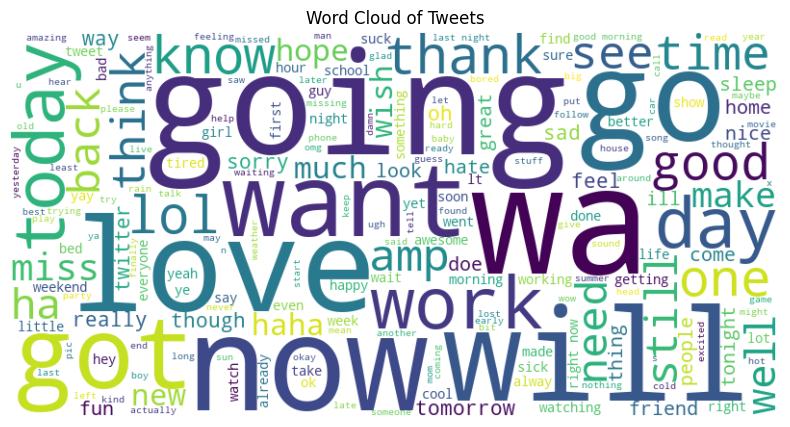

In [7]:
# Word Cloud Visualization
def plot_wordcloud(df, text_column):
    all_words = ' '.join(df[text_column])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Tweets')
    plt.show()

plot_wordcloud(balanced_df, 'text')

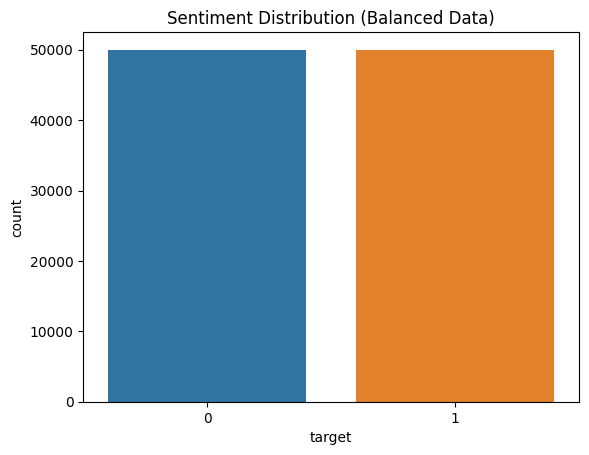

In [8]:
# Sentiment Distribution
sns.countplot(x='target', data=balanced_df)
plt.title('Sentiment Distribution (Balanced Data)')
plt.show()

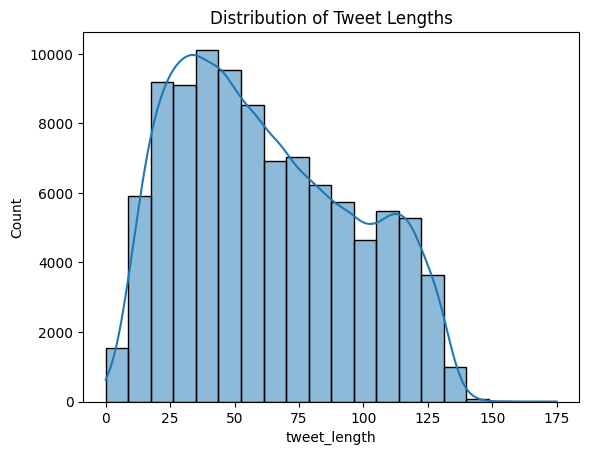

In [9]:
# Tweet Length Distribution
balanced_df['tweet_length'] = balanced_df['text'].apply(len)
sns.histplot(balanced_df['tweet_length'], bins=20, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.show()

In [10]:
# Word frequency analysis
#word_counts = Counter(' '.join(df['text']).split()).most_common(20)

# Data Preparation for Modeling

In [11]:
# Prepare embedding matrix using GloVe
# embedding_index = {}
# with open("/kaggle/input/glove-6b-100d/glove.6B.100d.txt", 'r') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embedding_index[word] = coefs
        
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df['text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(balanced_df['text'])
max_sequence_length = 20
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Prepare labels
y = balanced_df['target'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Create word embedding using Word2Vec
from gensim.models import Word2Vec

# Train Word2Vec model on the text data
sentences = [text.split() for text in balanced_df['text']]
word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec.model")
# Initialize the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate embedding matrix with Word2Vec vectors
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Embedding layer setup
embedding_layer = Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=max_sequence_length, 
                            trainable=False)

# Model Building and Training

In [13]:
# Build the LSTM model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(units=100, dropout=0.2, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,968,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,968,000 (22.77 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,968,000 (22.77 MB)

In [15]:
# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
epochs = 10
batch_size = 512

initial = time.time()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])
training_time = time.time() - initial

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6430 - loss: 0.6325 - val_accuracy: 0.7309 - val_loss: 0.5358
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7261 - loss: 0.5510 - val_accuracy: 0.7488 - val_loss: 0.5074
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7378 - loss: 0.5275 - val_accuracy: 0.7539 - val_loss: 0.4997
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7550 - loss: 0.5104 - val_accuracy: 0.7638 - val_loss: 0.4871
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7568 - loss: 0.5031 - val_accuracy: 0.7661 - val_loss: 0.4812
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7649 - loss: 0.4928 - val_accuracy: 0.7673 - val_loss: 0.4767
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7644 - loss: 0.4884 - val_accuracy: 0.7705 - val_loss: 0.4747
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7711 - loss: 0.4824 - val_acc

# Model Evaluation

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7750 - loss: 0.4621
Validation Loss: 0.4643, Validation Accuracy: 0.7749
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step


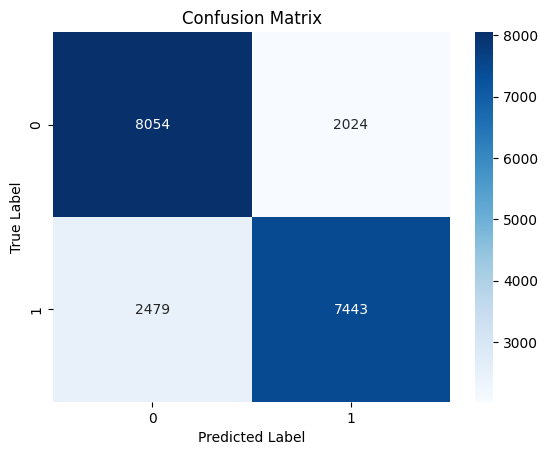

Accuracy: 0.7749
              precision    recall  f1-score   support

    Negative       0.76      0.80      0.78     10078
    Positive       0.79      0.75      0.77      9922

    accuracy                           0.77     20000
   macro avg       0.78      0.77      0.77     20000
weighted avg       0.78      0.77      0.77     20000



In [16]:
# Evaluate model performance
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report and accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Save the Model

In [17]:
# Save the trained model
model.save('sentiment_analysis_model.h5')

# Save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Prediction Function

In [18]:
def predict_sentiment(text):
    processed_text = ' '.join([lemmatizer.lemmatize(word) for word in re.findall(r'\w+', text.lower())])
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequence)
    sentiment = 'Positive' if prediction > 0.5 else 'Negative'
    return sentiment

# Test the prediction function with new samples
input_text1 = "I love this product! It's amazing and works perfectly."
input_text2 = "I hate this product! It's terrible and doesn't work at all."

print(f"Input Text: {input_text1}")
print(f"Predicted Sentiment: {predict_sentiment(input_text1)}")

print(f"Input Text: {input_text2}")
print(f"Predicted Sentiment: {predict_sentiment(input_text2)}")

Input Text: I love this product! It's amazing and works perfectly.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Predicted Sentiment: Positive
Input Text: I hate this product! It's terrible and doesn't work at all.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Sentiment: Negative
